# Amazon Alexa Review - Sentiment Analysis

Amazon, being one of the largest e-commerce platforms in the world, hosts a vast array of customer reviews and feedback for millions of products. Sentiment analysis on Amazon reviews provides valuable insights into how customers feel about various products and services. By understanding the sentiment expressed in these reviews, businesses, organizations, and researchers can gain valuable insights to inform decision-making, enhance customer experiences, and monitor brand reputation.

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install wordcloud

### Exploratory Data Analysis

In [70]:
#Load the data

data = pd.read_csv(r"/content/amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [8]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [9]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [10]:
#Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [11]:
#We will drop the null record

data.dropna(inplace=True)

In [12]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [13]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [71]:
#create a column in first postion, named that contains 1 to 3149

data.insert(0, 'id', range(1, len(data) + 1))


In [72]:
data.head()

,id,rating,date,variation,verified_reviews,feedback
0,1,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,2,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,3,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,4,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,5,31-Jul-18,Charcoal Fabric,Music,1


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [15]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [16]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [17]:
len(data)

3149

In [18]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

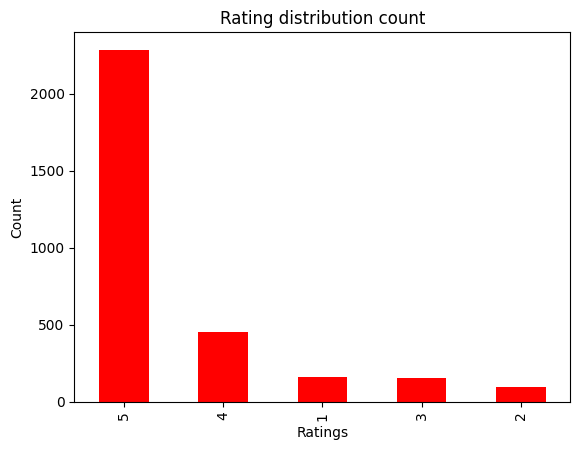

In [19]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [20]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart

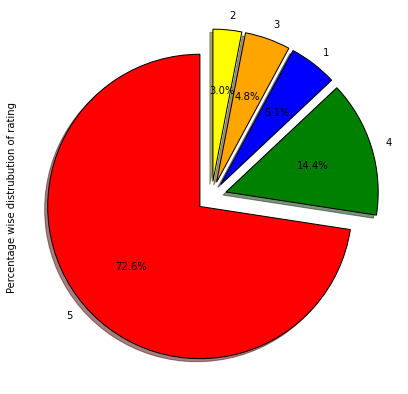

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [ ]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
1    2893
0     257
Name: feedback, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

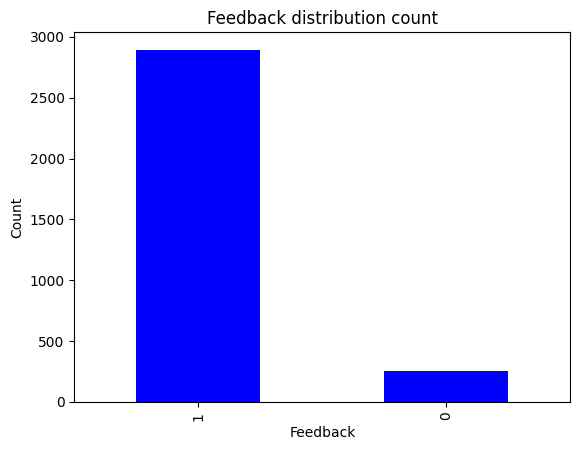

In [23]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
1    91.84
0     8.16
Name: feedback, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

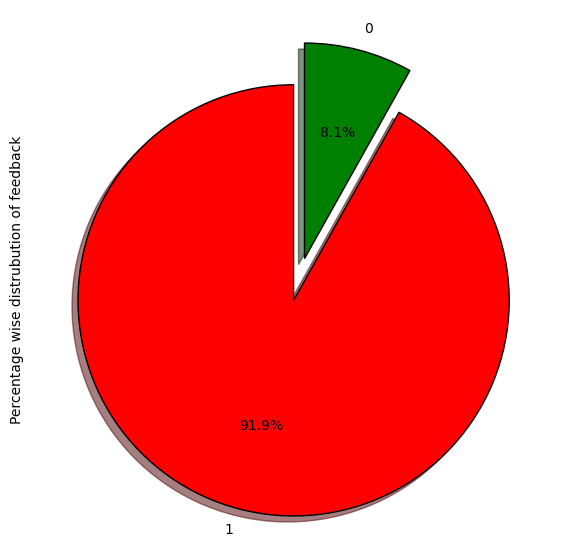

In [24]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [ ]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [ ]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

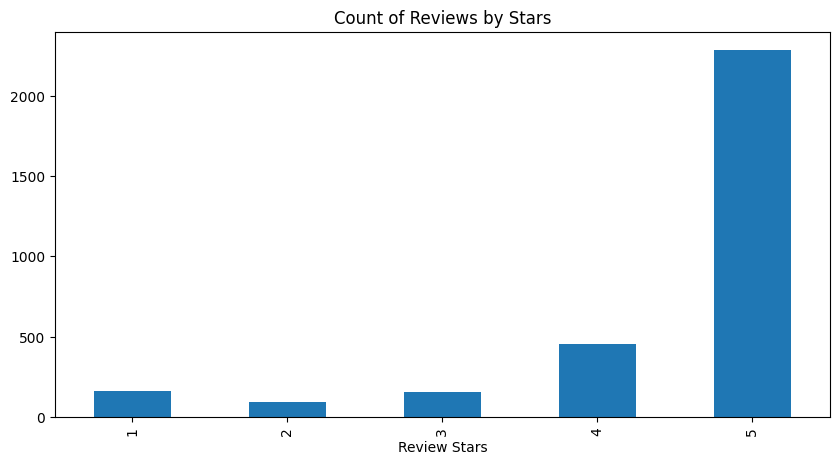

In [37]:
ax = data['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [40]:
example = data['verified_reviews'][70]
print(example)

Great sound in a small package—easy to set up and use; fun to own.


In [47]:

tokens = nltk.word_tokenize(example)
tokens[:10]

['Great',
 'sound',
 'in',
 'a',
 'small',
 'package—easy',
 'to',
 'set',
 'up',
 'and']

# VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:

1.Stop words are removed

2.each word is scored and combined to a total score.

In [52]:
 from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [53]:
 sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [54]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [55]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'compound': 0.8126}

In [77]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['verified_reviews']
    myid = row['id']
    # Handle missing values
    if pd.notna(text):
        res[myid] = sia.polarity_scores(text)
    else:
        res[myid] = {'neg': None, 'neu': None, 'pos': None, 'compound': None} # Or any default value you prefer

  0%|          | 0/3150 [00:00<?, ?it/s]

In [78]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(data, how='left')

In [79]:
# Now we have sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,rating,date,variation,verified_reviews,feedback
0,1,0.0,0.308,0.692,0.6696,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,2,0.0,0.193,0.807,0.636,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,3,0.102,0.784,0.114,-0.128,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,4,0.0,0.67,0.33,0.8957,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,0.0,1.0,0.0,0.0,5,31-Jul-18,Charcoal Fabric,Music,1


**Plot VADER results**

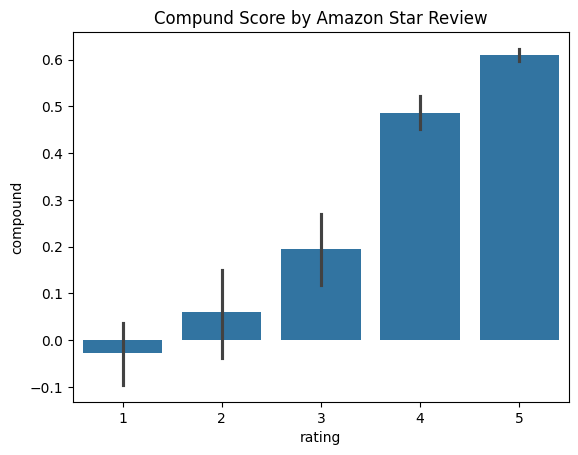

In [80]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

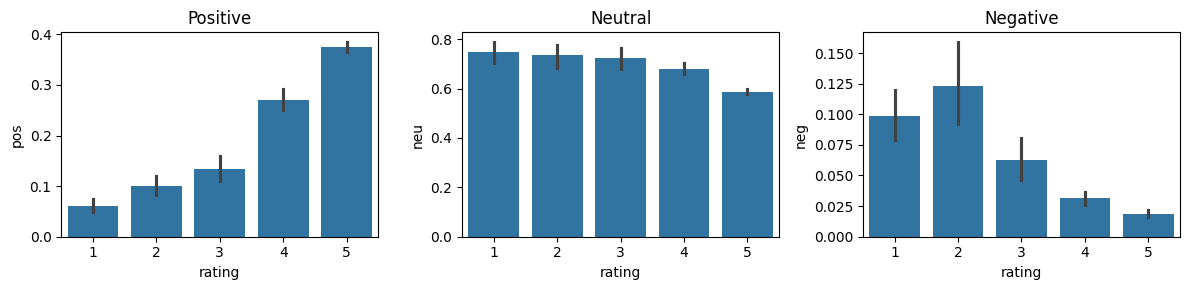

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [ ]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


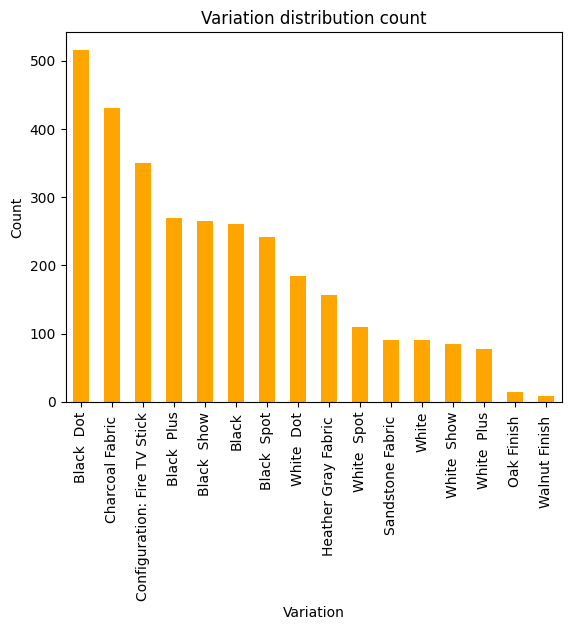

In [22]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


Mean rating according to variation

In [ ]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

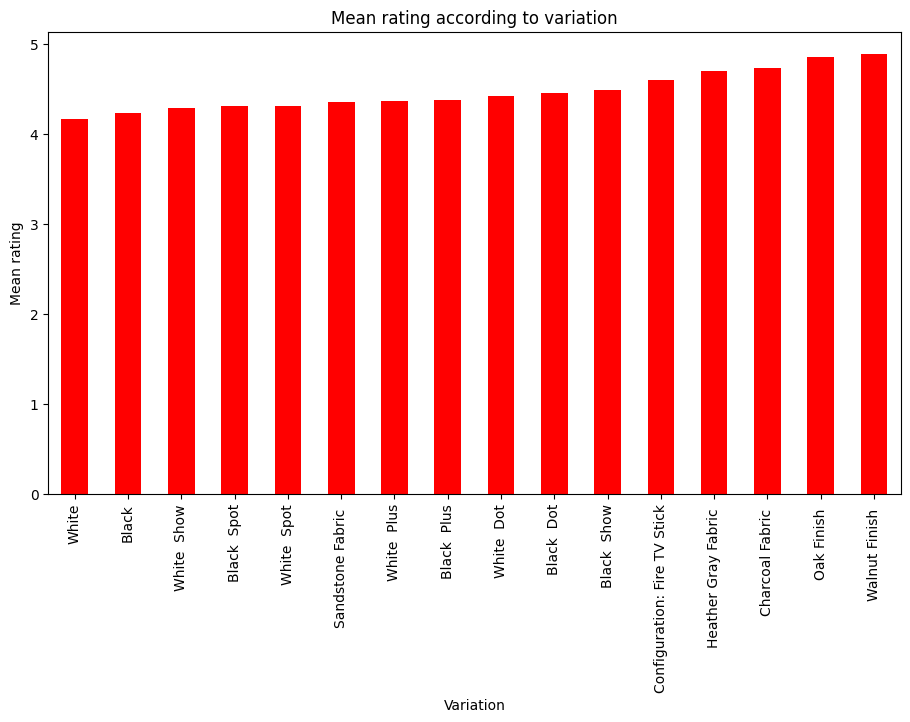

In [21]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'red', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [ ]:
data['length'].describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

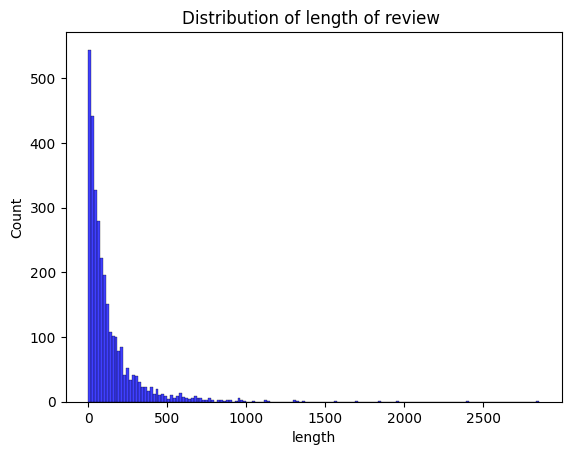

In [25]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

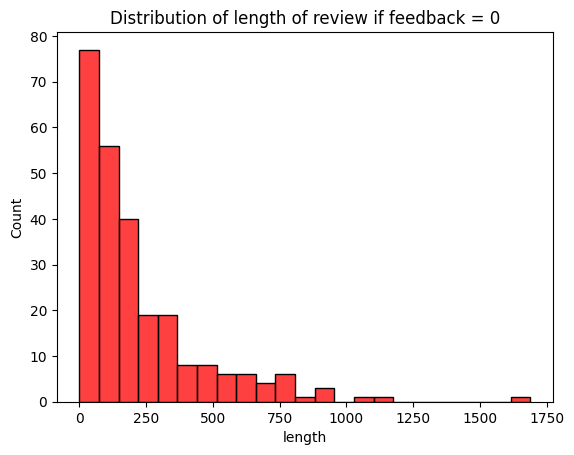

In [26]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

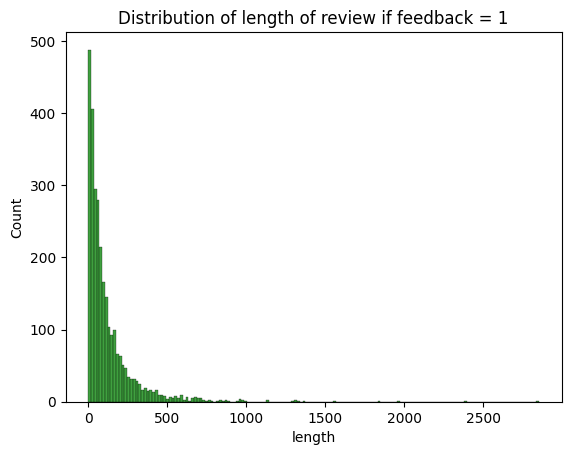

In [27]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

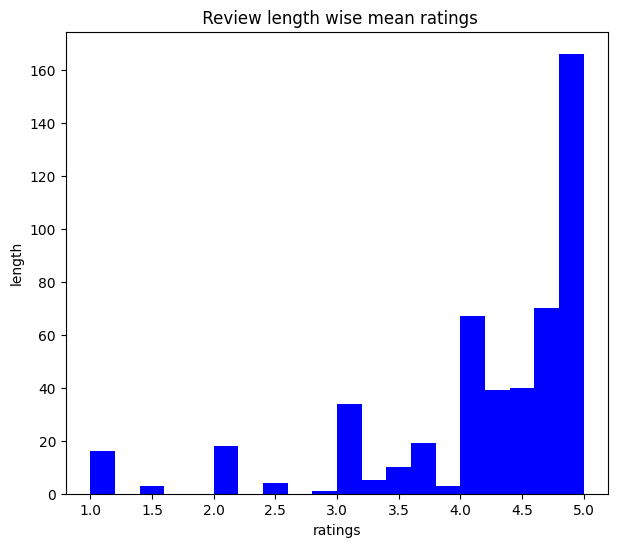

In [28]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [29]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

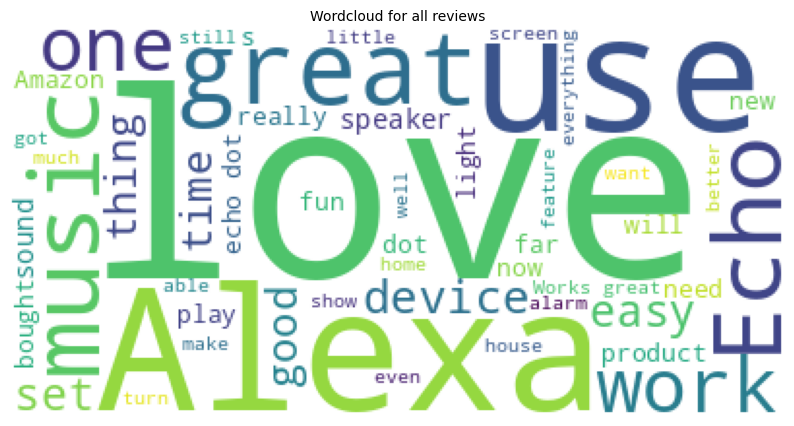

In [30]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [31]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


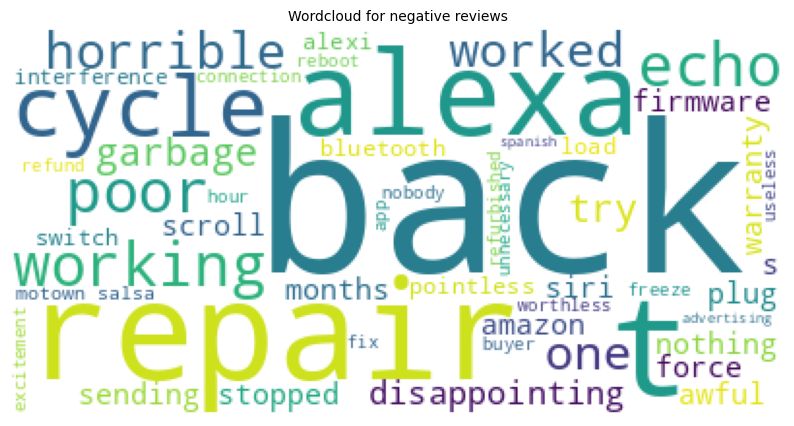

In [32]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

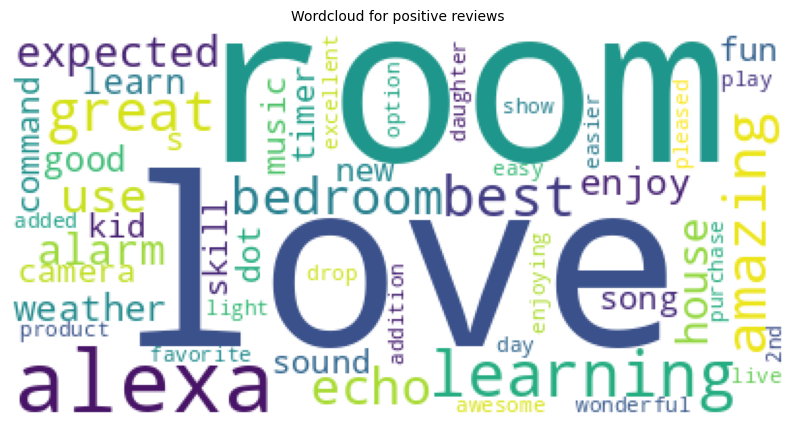

In [33]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# **Roberta Pretrained Model**
Use a model trained of a large corpus of data.

Transformer model accounts for the words but also the context related to other words.

In [82]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [83]:

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [84]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Great sound in a small package—easy to set up and use; fun to own.


{'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'compound': 0.8126}

In [85]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0022300836, 'roberta_neu': 0.020802274, 'roberta_pos': 0.9769677}


In [91]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['verified_reviews']
        myid = row['id']
        # Check if text is a valid string before processing
        if isinstance(text, str):
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = polarity_scores_roberta(text)
            both = {**vader_result_rename, **roberta_result}
            res[myid] = both
        else:
            print(f'Skipping id {myid} due to invalid text.')
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/3150 [00:00<?, ?it/s]

Skipping id 474 due to invalid text.
Broke for id 1323
Broke for id 2017


In [93]:
results_data = pd.DataFrame(res).T
results_data = results_data.reset_index().rename(columns={'index': 'id'})
results_data = results_data.merge(data, how='left')

In [94]:

results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

**Combine and compare**

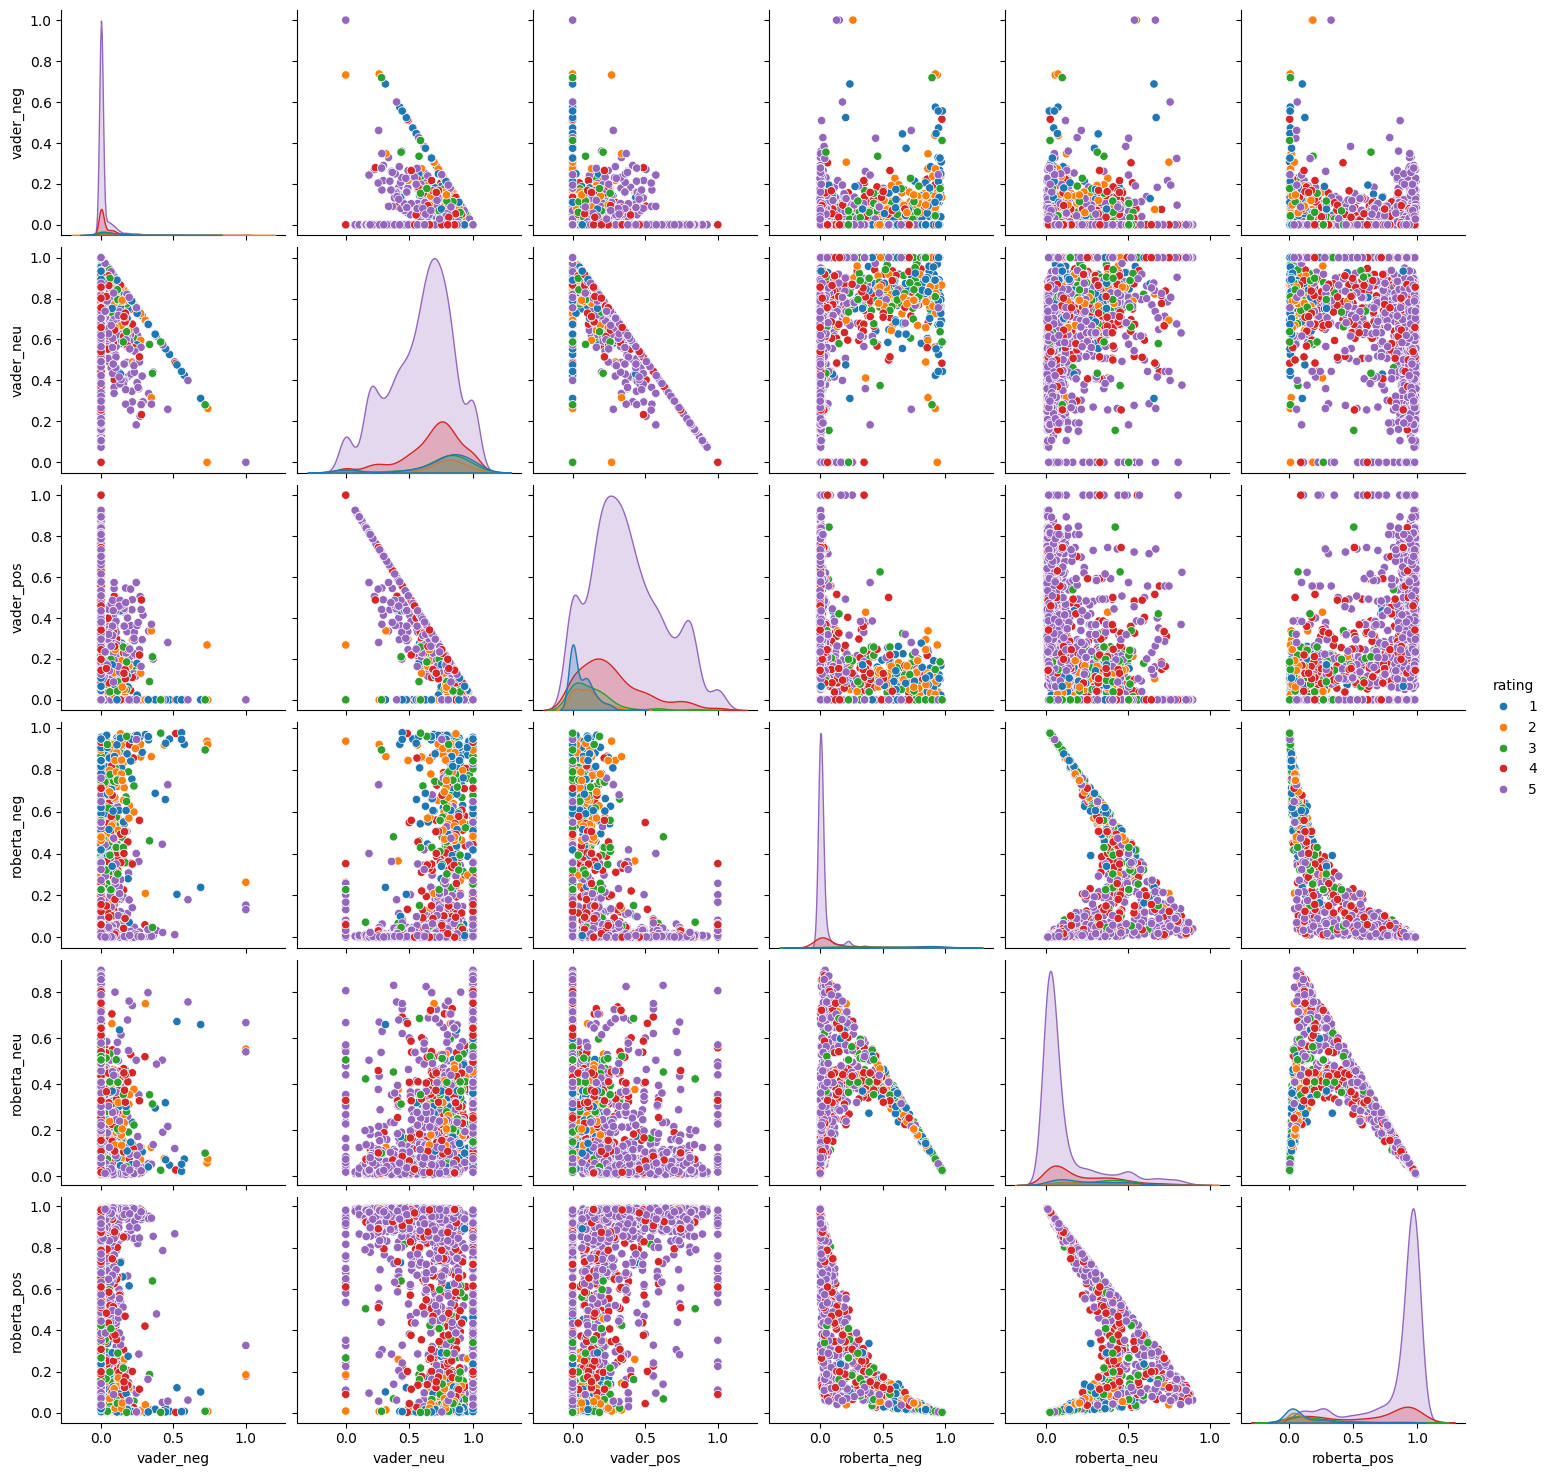

In [96]:
sns.pairplot(data=results_data,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

# Review Examples:
Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [101]:
# poitive sentiment 1-Star view

results_data.query('rating == 1') \
    .sort_values('roberta_pos', ascending=False)['verified_reviews'].values[0]

'The product sounded the same as the emoji speaker from five below my sister has ... and even that one has Bluetooth and doesn’t need to be plugged in. The only good thing about this is that you can speak to it.'

In [104]:
# poitive sentiment 1-Star view

results_data.query('rating == 1') \
    .sort_values('vader_pos', ascending=False)['verified_reviews'].values[0]

'received the wrong product...was so excited to install it ...all excitement gone. Thank you Amazon.'

In [106]:

# nevative sentiment 5-Star view

results_data.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['verified_reviews'].values[0]

'Dislike the volume. It does not sound loud enough.'

In [108]:
# nevative sentiment 5-Star view

results_data.query('rating == 5') \
    .sort_values('vader_neg', ascending=False)['verified_reviews'].values[0]

'no problem'

# Extra: The Transformers Pipeline
Quick & easy way to run sentiment predictions

In [109]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [110]:

sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [112]:

sent_pipeline('bad Product')

[{'label': 'NEGATIVE', 'score': 0.9997833371162415}]